# MGT-448 Assignment 1

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dtype = torch.double
device = torch.device("cuda:0")
np.set_printoptions(precision=3)

tolerance = 1e-5
def rel_error(x, y):
    return torch.max(torch.abs(x - y) / (torch.maximum(1e-8, torch.abs(x) + torch.abs(y))))

def sigmoid(x):
    return 1/(1+torch.exp(-x))

iteration = 20
reg = 1e-4

In [2]:
# load data
import pandas as pd
data_train = np.loadtxt(open('./logisticRegressionData/training.csv', "r"), delimiter=",", skiprows=0)
data_train = torch.from_numpy(data_train.astype(np.float64)).to(device)
print(data_train.size())
data_test = np.loadtxt(open('./logisticRegressionData/testing.csv', "r"), delimiter=",", skiprows=0)
data_test = torch.from_numpy(data_test.astype(np.float64)).to(device)
print(data_test.size())

torch.Size([198, 28])
torch.Size([325, 28])


In [3]:
x_train = data_train[:, 1:]
y_train = data_train[:, 0].view(data_train.size(0), 1)
x_test = data_test[:, 1:]
y_test = data_test[:, 0].view(data_test.size(0), 1)

## Binomial case

### 1
(a) In logistic regression, the classifier maps the vector-form input to classes. In binomial LR, if we represent the classes with binary numbers 0 or 1, and denote the ith input data as $x_i$ and output class as $y_i$, one typical example is $y_i = \text{sigmoid} (\theta^T x_i)$ where $x_i\in\mathbb{R}^d, \theta\in\mathbb{R}^{d}, y_i\in\mathbb{R}$. 

(b) Write $h_{\theta}(x_i) = \text{sigmoid}(\theta x_i)$. The likelihood function is 
$$L(\theta) = \Pi_{i=1}^n(h_{\theta}(x_i))^{y_i}(1-h_{\theta}(x_i))^{1-y_i}$$ 
We mainly use the log-likelihood function, which is 
$$l(\theta) = \Sigma_{i=1}^n y_i\ln(h_{\theta}(x_i))+(1-y_i)\ln(1-h_{\theta}(x_i))$$ 
Suppose we have $n$ input and output pairs. Combine all inputs to a single matrix $X$, each row of which is one input vector, then $X\in\mathbb{R}^{n\times d}$. Combine all output data as vector $y$. Then the mapping becomes $y = \text{sigmoid} (X \theta)$. Then the vectorized log-likelihood function is 
$$l(\theta) = y^T\ln(h_{\theta}(X))+(1-y)^T\ln(1-h_{\theta}(X))$$
The cost function would be $J(\theta) = - \frac{1}{n} l(\theta) + \frac{1}{2}\lambda\left\|\theta\right\|^2$. For the case of without regularization, the gradient of the loss function is 
$$\frac{\partial J(\theta)}{\partial \theta} = \frac{1}{n}X^T (h_{\theta}(X)-y)$$ and its hessian is 
$$H(\theta) = \frac{1}{n}X^T \text{diag} \left\{(1-h_{\theta}(X))h_{\theta}(X)\right\}X$$
By Newton's Method, the iteration for $\theta$ is 
$$\theta = \theta - (H(\theta))^{-1}\frac{\partial J(\theta)}{\partial \theta}$$
Our algorithm starts with initializing $\theta$ as zero vector and stops when $J(\theta)$ is smaller than a predifined value.

(c) Classification error is given by $1-\frac{1}{n} (y \text{ AND } (\text{sigmoid}(\theta X)>0.5))$.

(d)  1) the dependent variables should be binary. 2) the observations should be mutually independent and the inputs/independent variable are not highly correlated. 3) the dependent and independent variables are linearly correlated. 4) relatively large sample size.

## 2
In the update of $\theta$ in Newton's Method, we use 
$$\theta = \theta - (H(\theta))^{-1}\frac{\partial J(\theta)}{\partial \theta} + \lambda \theta$$

In [4]:
N, D_in, D_out = x_train.size(0), x_train.size(1), 1

y_train_binary = torch.fmod(y_train, 2)
y_test_binary = torch.fmod(y_test, 2)
# print(y_train_binary)
# theta_2 = torch.randn(1, D_out, device=device, dtype=dtype)

def log_likelyhood_bin_cal(hx, y):
    return torch.t(y).mm(torch.log(hx)) + torch.t(1-y).mm(torch.log(1-hx))

def accuracy_bin_cal(x, theta, y):
    # check accuracy for test data
    y_cal = x.mm(theta)
    sigmoid_y = sigmoid(y_cal) > 0.5
    return torch.mean(y * sigmoid_y.int())

def plot_loss_accuracy_bin(loss_array, accuracy_array):
    plt.rcParams['figure.figsize'] = (12.0, 4.0)
    pic1 = plt.subplot(1, 2, 1)
    pic1.plot(loss_array)
    pic1.set_ylabel("Loss")
    pic1.set_xlabel("Iteration")
    pic2 = plt.subplot(1, 2, 2)
    pic2.plot(accuracy_array)
    pic2.set_ylabel("Accuracy on training data")
    pic2.set_xlabel("Iteration")

### Newtons's Method

Parameters theta_1(Transpose) is:
 [[ 1.057e+00  2.273e+00 -2.084e+00  3.072e-03 -7.010e+00  6.582e+00
  -7.115e-01  9.534e-01 -3.766e+00  1.439e+00  1.329e+00 -1.598e+00
   4.141e-01 -6.146e+00  6.085e+00 -6.501e-01  6.027e-01 -1.540e+00
   1.144e+00  2.042e-01 -6.010e-01  1.599e-01 -3.249e+00  3.820e+00
  -1.089e+00 -6.903e-01  6.860e-01]]


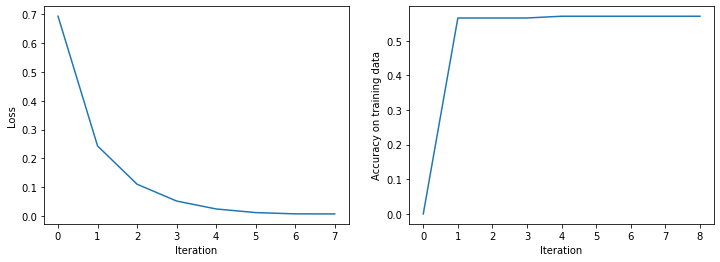

In [5]:
i, loss, step_size = 0, 1.0, 1.0
theta_1 = torch.zeros(D_in, D_out, device=device, dtype=dtype)
loss_array = []
accuracy_array = []
while i < iteration and loss > tolerance:
    i = i+1
    # forward pass
    scores = x_train.mm(theta_1)
    # computing loss
    h_1 = sigmoid(scores)
    h_0 = 1 - h_1
    log_likelyhood = log_likelyhood_bin_cal(h_1, y_train_binary)
    loss = -log_likelyhood/N + 0.5*reg*torch.sum(theta_1*theta_1)
    # print("Loss is: ", loss.data.cpu().numpy())
    loss_array.append(torch.flatten(loss * (loss > tolerance)).data.cpu().numpy())
    
    # accuracy on training data
    accuracy = accuracy_bin_cal(x_train, theta_1, y_train_binary)
    accuracy_array.append(torch.flatten(accuracy).data.cpu().numpy())
    
    # optimization
    grad_loss = torch.t(x_train).mm(h_1-y_train_binary)
    # print(grad_loss.size())
    temp_diag = torch.diag(torch.flatten(h_0*h_1 + tolerance))
    # print(temp_diag.size(), x_train.size())
    hessian_loss = torch.t(x_train).mm(temp_diag).mm(x_train)
    dtheta_1 = torch.inverse(hessian_loss).mm(grad_loss) 
    theta_1 -= step_size * dtheta_1 + reg*theta_1

plot_loss_accuracy_bin(loss_array, accuracy_array)
print("Parameters theta_1(Transpose) is:\n", theta_1.data.cpu().numpy().T)

In [6]:
# check accuracy for test data
accuracy = accuracy_bin_cal(x_test, theta_1, y_test_binary)
print("Accuracy is ", accuracy.item())

Accuracy is  0.6861538467928767


### Backtracking line search for Newton's Method in binomial case

In [7]:
i, loss, step_size = 0, 1.0, 1.0
theta_1 = torch.zeros(D_in, D_out, device=device, dtype=dtype)

alpha, rho, c = 1.0, 0.9, 0.5
criterion_v = torch.ones(1, 1, device=device, dtype=dtype)

while criterion_v and loss > tolerance and i < iteration:
    i = i+1
    # forward pass
    scores = x_train.mm(theta_1)
    # computing loss
    h_1 = sigmoid(scores)
    h_0 = 1 - h_1
    log_likelyhood = log_likelyhood_bin_cal(h_1, y_train_binary)
    loss = -log_likelyhood/N + 0.5*reg*torch.sum(theta_1*theta_1)
    print("Loss is: ", loss.data.cpu().numpy())
    
    # optimization
    grad_loss = torch.t(x_train).mm(h_1-y_train_binary)
    # print(grad_loss.size())
    temp_diag = torch.diag(torch.flatten(h_0*h_1 + tolerance))
    # print(temp_diag.size(), x_train.size())
    hessian_loss = torch.t(x_train).mm(temp_diag).mm(x_train)
    dtheta_1 = torch.inverse(hessian_loss).mm(grad_loss) 
    theta_1 -= step_size * dtheta_1 + reg*theta_1
    
    # backtracking linear search related
    pk = -dtheta_1
    alpha = rho*alpha
    criterion = (-log_likelyhood_bin_cal(sigmoid(x_train.mm(theta_1+alpha*pk)), y_train_binary)/N \
                + log_likelyhood_bin_cal(h_1, y_train_binary)/N \
                - c*alpha*torch.t(grad_loss/N).mm(pk)) > 0
    criterion_v = torch.sum(criterion.int())
    # print("Criterion function value is: ", criterion)

print("Parameters theta_1(Transpose) is:\n", theta_1.data.cpu().numpy().T)

Loss is:  [[0.693]]
Parameters theta_1(Transpose) is:
 [[-0.122  0.066  0.03  -0.022 -0.517  0.382  0.176  0.436 -0.433 -0.043
  -0.045  0.098 -0.018 -0.486  0.445  0.176  0.33  -0.267 -0.029 -0.013
   0.108  0.008 -0.189  0.185  0.063 -0.332  0.302]]


In [8]:
# check accuracy for test data
accuracy = accuracy_bin_cal(x_test, theta_1, y_test_binary)
print("Accuracy is ", accuracy.item())

Accuracy is  0.6769230775535107


### Gradient descent

Parameters theta_1(transpose) is:
 [[-9.877e-04 -2.472e-04 -1.425e-04 -2.264e-05  2.213e-04  6.550e-04
   4.905e-04 -5.186e-04 -4.256e-04  2.802e-03  1.064e-03  1.689e-03
   1.622e-03  1.870e-04  3.200e-04  7.574e-04  1.000e-03  1.314e-03
  -3.461e-04 -3.832e-05 -9.231e-05 -3.518e-04 -2.020e-05 -8.973e-05
  -3.640e-04 -6.152e-05 -9.547e-05]]


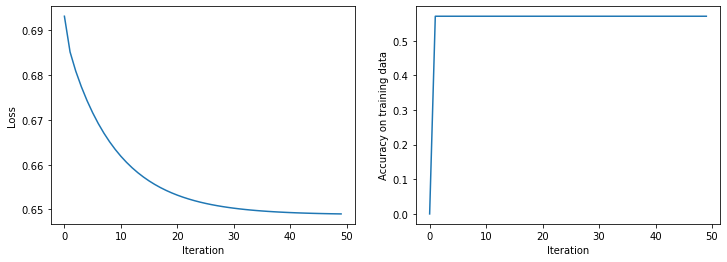

In [9]:
i, loss, step_size = 0, 1.0, 5e-5
decay_rate = 0.9
theta_1 = torch.zeros(D_in, D_out, device=device, dtype=dtype)
loss_array, accuracy_array = [], []
while i < 50 and (loss > tolerance or torch.isinf(loss)):
    i = i+1
    # forward pass
    scores = x_train.mm(theta_1)
    # computing loss
    h_1 =sigmoid(scores)
    h_0 = 1 - h_1
    log_likelyhood = log_likelyhood_bin_cal(h_1, y_train_binary)
    loss = -log_likelyhood/N + 0.5*reg*torch.sum(theta_1*theta_1)
    loss_array.append(torch.flatten(loss * (loss > tolerance)).data.cpu().numpy())
    
    # accuracy on training data
    accuracy = accuracy_bin_cal(x_train, theta_1, y_train_binary)
    accuracy_array.append(torch.flatten(accuracy).data.cpu().numpy())
    
    # optimization
    grad_loss = torch.t(x_train).mm(h_1-y_train_binary)
    dtheta_1 = grad_loss/N 
    theta_1 -= step_size * dtheta_1 + reg*theta_1
    step_size = step_size * decay_rate
    
plot_loss_accuracy_bin(loss_array, accuracy_array)
print("Parameters theta_1(transpose) is:\n", theta_1.data.cpu().numpy().T)

In [10]:
# check accuracy for test data
accuracy = accuracy_bin_cal(x_test, theta_1, y_test_binary)
print("Accuracy is ", accuracy.item())

Accuracy is  0.7353846160694957


### Stochastic gradient descent

In [11]:
decay_rate = 0.9
step_sizes = [5e-4, 1e-3, 8e-4, 1e-4]
batch_sizes = [1, 16, 32, N]
iterations = [100, 100, 100, 100]
theta_s = torch.zeros(D_in, D_out, len(batch_sizes), device=device, dtype=dtype)

y_test_binary = torch.fmod(y_test, 2)

for k in range(len(batch_sizes)):
    batch_size = batch_sizes[k]
    step_size = step_sizes[k]
    iteration = iterations[k]
    loss = 1.0
    theta_1 = torch.zeros(D_in, D_out, device=device, dtype=dtype)
    perm_seq = torch.randperm(N)
    x_train_perm, y_train_binary_perm = x_train[perm_seq, :], y_train_binary[perm_seq, :]
    
    for j in range(int(np.ceil(N/batch_size))):
        # print("j is ", j)
        start_ind = batch_size*j
        end_ind = np.minimum(N, start_ind+batch_size)
        # print("end_ind is ",  end_ind)
        x_batch = x_train_perm[start_ind:end_ind]
        y_batch = y_train_binary_perm[start_ind:end_ind]
        N_batch = end_ind - start_ind
        
        i = 0
        while i < iteration:
            i = i+1
            step_size = step_size * decay_rate
            # forward pass
            scores = x_batch.mm(theta_1)
            # computing loss
            h_1 = sigmoid(scores)
            h_0 = 1 - h_1
            log_likelyhood = log_likelyhood_bin_cal(h_1, y_batch)
            loss = -log_likelyhood/N_batch + 0.5*reg*torch.sum(theta_1*theta_1)
            # print("Loss for batch size of ", batch_size, " is: ", loss.item())
            # optimization
            grad_loss = torch.t(x_batch).mm(h_1-y_batch)
            dtheta_1 = grad_loss/N_batch 
            theta_1 -= step_size * dtheta_1 + reg*theta_1
    
    theta_s[:, :, k] = theta_1
    # print("\nParameters theta_1 is:\n", theta_1.data.cpu().numpy())
    accuracy = accuracy_bin_cal(x_test, theta_1, y_test_binary)
    print("Accuracy for batch size of ", batch_size, " is ", accuracy.item(), "\n")


Accuracy for batch size of  1  is  0.0 

Accuracy for batch size of  16  is  0.6769230775535107 

Accuracy for batch size of  32  is  0.7015384621918201 

Accuracy for batch size of  198  is  0.7169230775907636 



## Multinomial case

In [12]:
num_classes = 4
N, D_in, D_out = x_train.size(0), x_train.size(1), num_classes

y_train_expand = torch.zeros(y_train.size(0), num_classes, device=device, dtype=dtype)

y_test_expand = torch.zeros(y_test.size(0), num_classes, device=device, dtype=dtype)
for i in range(num_classes):
    temp = y_test == i+1
    y_test_expand[:, i] = torch.flatten(temp.int())
    
# print(y_train_expand.size())
for i in range(num_classes):
    temp = y_train == i+1
    y_train_expand[:, i] = torch.flatten(temp.int())

def log_likelyhood_mul_cal(hx, y):
    temp = torch.t(y).mm(torch.log(hx)) + torch.t(1-y).mm(torch.log(1-hx))
    return torch.diag(temp).view(num_classes, 1)

def accuracy_mul_cal(x, theta, y):
    y_cal = x.mm(theta)
    sigmoid_y = sigmoid(y_cal) > 0.5
    # print(sigmoid_y)
    accuracy = torch.true_divide(torch.sum(torch.abs(y * sigmoid_y.int())), y.size(0))
    return accuracy
    

### Newton's Method

Parameters theta_2 is:
 [[ 1.147 -0.278 -0.757 -0.69 ]
 [-1.96  -2.543 -1.328 -0.947]
 [-1.082  1.433  0.903  1.148]
 [-0.116 -0.197 -0.243 -0.778]
 [-0.708  6.223  0.516 -7.925]
 [ 0.803 -2.69   3.032  1.651]
 [-0.672 -0.155  0.836  1.806]
 [-0.064 -1.635  7.541  1.308]
 [ 1.176  2.103 -7.393 -0.224]
 [ 0.639 -0.745 -0.016 -0.417]
 [-1.648 -1.006 -1.494 -0.561]
 [ 0.364  0.268  0.598  0.818]
 [ 0.601 -0.462 -0.251 -0.971]
 [-1.464  5.625  0.135 -8.616]
 [ 0.789 -2.332  3.184  1.99 ]
 [-0.42  -0.389  0.519  1.818]
 [ 0.213 -0.98   6.359  1.529]
 [ 1.388  1.982 -4.876 -1.632]
 [ 0.31  -0.263 -0.517  0.505]
 [-1.147 -0.117 -0.397  2.351]
 [-0.081 -0.032  2.351 -2.2  ]
 [ 0.213 -0.219 -0.217 -1.291]
 [-1.895  3.09  -1.066 -4.717]
 [ 2.522 -1.214  1.29   3.31 ]
 [-0.485 -0.239  0.83   1.353]
 [-0.958 -0.364 -2.136  2.833]
 [ 2.222  0.419  0.747 -2.961]]


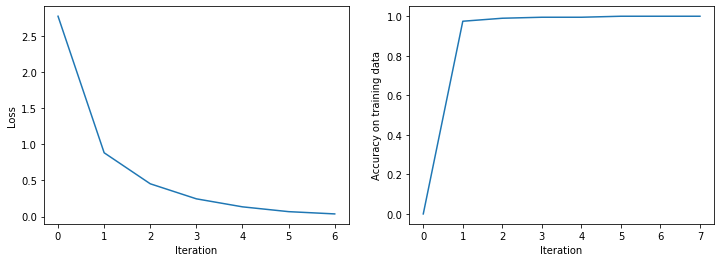

In [13]:
i, step_size = 0, 1.0
loss = torch.ones(num_classes, device=device, dtype=dtype)
theta_2 = torch.zeros(D_in, D_out, device=device, dtype=dtype)
loss_array = []
accuracy_array = []

while i < iteration and torch.max(loss) > tolerance:
    i = i+1
    # forward pass
    scores = x_train.mm(theta_2)
    # computing loss
    h_1 = 1 / (1+torch.exp(-scores))
    h_0 = 1 - h_1
    log_likelyhood = log_likelyhood_mul_cal(h_1, y_train_expand)
    loss = -log_likelyhood/N + 0.5*reg*torch.diag(torch.t(theta_2).mm(theta_2)).view(num_classes, 1)
    # print("Loss is ", loss.data.cpu().numpy().T)
    
    loss_array.append(torch.sum(torch.flatten(loss * (loss > tolerance))).data.cpu().numpy())
    # accuracy on training data
    accuracy = accuracy_mul_cal(x_train, theta_2, y_train_expand)
    accuracy_array.append(torch.flatten(accuracy).data.cpu().numpy())
    
    # optimization
    grad_loss = torch.t(x_train).mm(h_1-y_train_expand)
    hessian_loss = torch.zeros(D_in, D_in, num_classes, device=device, dtype=dtype)
    dtheta_2 = torch.zeros(theta_2.size(), device=device, dtype=dtype)
    for i in range(num_classes):
        temp_diag = torch.diag(torch.flatten(h_0[:, i]*h_1[:, i]+tolerance))
        hessian_loss[:, :, i] = torch.t(x_train).mm(temp_diag).mm(x_train)
        temp = torch.inverse(hessian_loss[:, :, i]).mm(grad_loss[:, i].view(D_in, 1))
        dtheta_2[:, i] = torch.flatten(torch.inverse(hessian_loss[:, :, i]).mm(grad_loss[:, i].view(D_in, 1)))
    theta_2 -= step_size * dtheta_2 + reg*theta_2    
    
print("Parameters theta_2 is:\n", theta_2.data.cpu().numpy())
plot_loss_accuracy_bin(loss_array, accuracy_array)

In [14]:
# check accuracy for test data
accuracy = accuracy_mul_cal(x_test, theta_2, y_test_expand)
print("Accuracy is ", accuracy.item())

Accuracy is  0.7876923076923077


### Backtrack line search for Newton's Method in multinomial case

In [15]:
i, step_size = 0, 1.0
loss = torch.ones(num_classes, device=device, dtype=dtype)
theta_2 = torch.zeros(D_in, D_out, device=device, dtype=dtype)

alpha, rho, c = 1.0, 0.5, 0.5
criterion_v = torch.ones(1, 1, device=device, dtype=dtype)

while i < iteration and torch.max(loss) > tolerance and criterion_v:
    i = i+1
    # forward pass
    scores = x_train.mm(theta_2)
    # computing loss
    h_1 = sigmoid(scores)
    h_0 = 1 - h_1
    log_likelyhood = log_likelyhood_mul_cal(h_1, y_train_expand)
    loss = -log_likelyhood/N + 0.5*reg*torch.diag(torch.t(theta_2).mm(theta_2)).view(num_classes, 1)
    print("Loss is ", loss.data.cpu().numpy().T)
    
    # optimization
    grad_loss = torch.t(x_train).mm(h_1-y_train_expand)
    hessian_loss = torch.zeros(D_in, D_in, num_classes, device=device, dtype=dtype)
    dtheta_2 = torch.zeros(theta_2.size(), device=device, dtype=dtype)
    for i in range(num_classes):
        temp_diag = torch.diag(torch.flatten(h_0[:, i]*h_1[:, i]+tolerance))
        hessian_loss[:, :, i] = torch.t(x_train).mm(temp_diag).mm(x_train)
        temp = torch.inverse(hessian_loss[:, :, i]).mm(grad_loss[:, i].view(D_in, 1))
        dtheta_2[:, i] = torch.flatten(torch.inverse(hessian_loss[:, :, i]).mm(grad_loss[:, i].view(D_in, 1)))
    theta_2 -= step_size * dtheta_2 + reg*theta_2
    
    # backtracing line search related
    pk = -dtheta_2
    alpha = rho*alpha
    criterion = (-log_likelyhood_mul_cal(x_train.mm(theta_2+alpha*pk), y_train_expand)/N \
                +log_likelyhood_mul_cal(h_1, y_train_expand)/N \
                -c*alpha*torch.diag(torch.t(grad_loss/N).mm(pk)).view(num_classes, 1))>0
    criterion_v = torch.sum(criterion.int())
    print("Criterion function value is: ", criterion_v.item())
    
print("\nParameters theta_2 is:\n", theta_2.data.cpu().numpy())

Loss is  [[0.693 0.693 0.693 0.693]]
Criterion function value is:  0

Parameters theta_2 is:
 [[-0.055  0.114 -0.073  0.002]
 [-0.029 -0.027  0.096 -0.038]
 [ 0.13  -0.071 -0.101  0.04 ]
 [ 0.101 -0.041 -0.125  0.061]
 [ 0.266  0.357 -0.824  0.121]
 [-0.249 -0.092  0.658 -0.263]
 [-0.012 -0.115  0.194 -0.053]
 [ 0.057 -0.289  0.441 -0.086]
 [-0.069  0.236 -0.439  0.122]
 [-0.043  0.025 -0.006  0.012]
 [-0.169  0.168  0.125 -0.123]
 [ 0.251 -0.201 -0.154  0.102]
 [ 0.093 -0.028 -0.113  0.044]
 [ 0.261  0.365 -0.786  0.081]
 [-0.119 -0.172  0.589 -0.247]
 [ 0.073 -0.148  0.111 -0.021]
 [ 0.192 -0.278  0.2    0.01 ]
 [-0.218  0.253 -0.125 -0.062]
 [-0.047  0.012  0.016  0.016]
 [-0.032  0.035  0.027 -0.015]
 [ 0.075 -0.071  0.027 -0.043]
 [ 0.052 -0.016 -0.046  0.007]
 [ 0.038  0.264 -0.238 -0.085]
 [ 0.067 -0.193  0.128  0.019]
 [ 0.017 -0.051  0.049 -0.01 ]
 [-0.433  0.219  0.114  0.125]
 [ 0.398 -0.21  -0.118 -0.115]]


In [16]:
accuracy = accuracy_mul_cal(x_test, theta_2, y_test_expand)
print("Accuracy is ", accuracy.item())

Accuracy is  0.7661538461538462


### Gradient descent

Parameters theta_2 is:
 [[ 6.886e-03  4.333e-02 -5.392e-02 -1.312e-02]
 [-2.779e-02 -3.033e-02  1.772e-02  1.717e-02]
 [-1.811e-02 -2.141e-02  3.214e-03  7.155e-03]
 [ 1.001e-03  2.196e-02 -1.689e-02 -1.622e-02]
 [-8.887e-03 -2.193e-02  6.484e-03  1.149e-02]
 [ 3.018e-03 -1.841e-02 -1.516e-03  7.108e-04]
 [-2.244e-02  1.759e-02  3.252e-02 -2.516e-02]
 [-3.031e-03 -1.274e-02 -2.303e-02  2.087e-02]
 [ 5.330e-03 -6.157e-03 -3.876e-02  1.656e-02]
 [ 3.130e-02 -5.583e-02  4.635e-02 -1.932e-02]
 [ 4.527e-02  2.492e-02 -2.107e-02 -3.092e-02]
 [ 5.044e-02  1.043e-02 -9.154e-03 -3.285e-02]
 [ 3.111e-02 -3.092e-02  1.271e-02 -1.534e-02]
 [ 1.752e-02  1.949e-02 -8.081e-03 -1.919e-02]
 [ 1.700e-02  1.229e-02 -1.693e-03 -1.886e-02]
 [ 4.777e-02 -2.613e-02 -3.602e-02  1.192e-03]
 [ 1.359e-02  1.021e-02  2.090e-02 -3.075e-02]
 [ 1.374e-02  1.312e-03  3.479e-02 -3.408e-02]
 [-1.019e-03 -2.109e-03  2.172e-03  5.650e-03]
 [ 5.284e-04  1.141e-03 -5.201e-04  4.290e-04]
 [ 5.961e-04 -1.099e-05  2.439e-04  

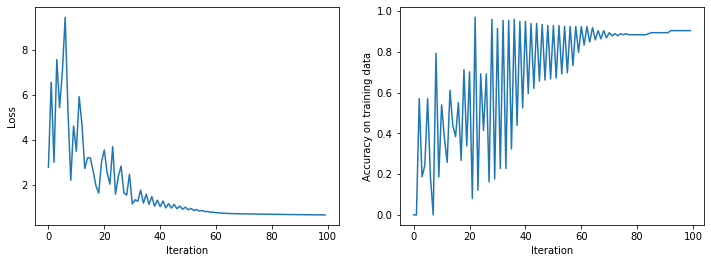

In [17]:
i, step_size = 0, 5e-4
decay_rate = 0.99
loss = torch.ones(num_classes, device=device, dtype=dtype)
theta_2 = torch.zeros(D_in, D_out, device=device, dtype=dtype)
loss_array = []
accuracy_array = []

while i < iteration and (torch.max(loss) > tolerance or torch.sum(torch.isinf(loss).int())):
    i = i+1
    # forward pass
    scores = x_train.mm(theta_2)
    # computing loss
    h_1 = sigmoid(scores)
    h_0 = 1 - h_1
    log_likelyhood = log_likelyhood_mul_cal(h_1, y_train_expand)
    loss = -log_likelyhood/N + 0.5*reg*torch.diag(torch.t(theta_2).mm(theta_2)).view(num_classes, 1)
    # print("Loss is ", loss.data.cpu().numpy().T)
    
    loss_array.append(torch.sum(torch.flatten(loss * (loss > tolerance))).data.cpu().numpy())
    # accuracy on training data
    accuracy = accuracy_mul_cal(x_train, theta_2, y_train_expand)
    accuracy_array.append(torch.flatten(accuracy).data.cpu().numpy())
    
    # optimization
    grad_loss = torch.t(x_train).mm(h_1-y_train_expand)
    theta_2 -= step_size * grad_loss/N + reg*theta_2
    step_size = step_size * decay_rate

plot_loss_accuracy_bin(loss_array, accuracy_array)
print("Parameters theta_2 is:\n", theta_2.data.cpu().numpy())

In [18]:
accuracy = accuracy_mul_cal(x_test, theta_2, y_test_expand)
print("Accuracy is ", accuracy.item())

Accuracy is  0.7138461538461538


### 5

The gradient descent has less computation when updating the parameters, while some parameter, like the decay rate/learning rate should be selected carefully as it's likely that the results from gradient descent is ocsillating arount the optimal point and the step size should decrease during the iterations, or the loss may not converge at all.

### Stochastic gradient descent

In [19]:
decay_rate = 0.95

batch_sizes = [1, 16, 32, N]
step_sizes = [1e-2, 1e-2, 1e-2, 6e-4]
iterations = [50, 100, 100, 100]
theta_s = torch.zeros(D_in, D_out, len(batch_sizes), device=device, dtype=dtype)

y_test_expand = torch.zeros(y_test.size(0), num_classes, device=device, dtype=dtype)
# print(y_test_expand.size())
for i in range(num_classes):
    temp = y_test == i+1
    y_test_expand[:, i] = torch.flatten(temp.int())

for k in range(len(batch_sizes)):
    batch_size = batch_sizes[k]
    step_size = step_sizes[k]
    iteration = iterations[k]
    loss = torch.ones(num_classes, device=device, dtype=dtype)
    theta_2 = torch.zeros(D_in, D_out, device=device, dtype=dtype)
    perm_seq = torch.randperm(N)
    x_train_perm, y_train_expand_perm = x_train[perm_seq, :], y_train_expand[perm_seq, :]
    
    for j in range(int(np.ceil(N/batch_size))):
        # print("j is ", j)
        start_ind = batch_size*j
        end_ind = np.minimum(N, start_ind+batch_size)
        # print("end_ind is ",  end_ind)
        x_batch = x_train_perm[start_ind:end_ind]
        y_batch = y_train_expand_perm[start_ind:end_ind]
        N_batch = end_ind - start_ind
        
        i = 0
        while i < iteration and (torch.max(loss) > tolerance or torch.sum(torch.isinf(loss).int())):
            i = i+1
            step_size = step_size * decay_rate
            # forward pass
            scores = x_batch.mm(theta_2)
            # computing loss
            h_1 = sigmoid(scores)
            h_0 = 1 - h_1
            log_likelyhood = log_likelyhood_mul_cal(h_1, y_batch)
            loss = -log_likelyhood/N + 0.5*reg*torch.diag(torch.t(theta_2).mm(theta_2)).view(num_classes, 1)
            # print("Loss for batch size of ", batch_size, " is: ", loss.data.cpu().numpy().T)            
            # optimization
            grad_loss = torch.t(x_batch).mm(h_1-y_batch)
            theta_2 -= step_size * grad_loss/N + reg*theta_2
    
    theta_s[:, :, k] = theta_2
    accuracy = accuracy_mul_cal(x_test, theta_2, y_test_expand)
    print("Accuracy for batch size of ", batch_size, " is ", accuracy.item(), "\n")


Accuracy for batch size of  1  is  0.3230769230769231 

Accuracy for batch size of  16  is  0.5107692307692308 

Accuracy for batch size of  32  is  0.7476923076923077 

Accuracy for batch size of  198  is  0.5723076923076923 

